In [1]:
import numpy as np
import h5py

import corner
import emcee

# import yaml
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d


import matplotlib.ticker as tck
from matplotlib import cm, colors
import matplotlib as mpl
from astropy.cosmology import FlatLambdaCDM

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'serif'



### (1) Read hdf5 file;
### (2) Do the stacking (peak matched using ${\tt cen\_match}$) and normalizing to the narrow tomo bin angular cross-correlation function $\hat{w}_{\rm ur}(z_j)$ across wide tomo bin. The jackknife resampling is also performed in this step.  

In [2]:
def load_wdd_data(filename):
    """
    Load the data saved from step 1.

    Parameters:
    - filename: Name of the HDF5 file to load.

    Returns:
    - data: Dictionary containing the loaded data arrays.
    """
    with h5py.File(filename, 'r') as hf:
        #rbins = hf['rbins'][:]
        #dr_bins = hf['dr_bins'][:]
        #rbins_cen = hf['rbins_cen'][:]
        z_i_bins = hf['z_i_bins'][:]
        z_j_bins = hf['z_j_bins'][:]
        wDuDr = hf['wDuDr'][:]
        wDuRr = hf['wDuRr'][:]
        Nr = hf['Nr'][:]
        Rr = hf['Rr'][:]
        jk_patch_labels = hf['jk_patch_labels'][:]
    return {
        #'rbins': rbins,
        #'dr_bins': dr_bins,
        #'rbins_cen': rbins_cen,
        'z_i_bins': z_i_bins,
        'z_j_bins': z_j_bins,
        'wDuDr': wDuDr,
        'wDuRr': wDuRr,
        'Nr': Nr,
        'Rr': Rr,
        'jk_patch_labels': jk_patch_labels
    }


def cen_match(z_cen, n_stacking, z_j_bins_cen):
    """
    Match the center of w_ur and select N points of z_j to perform the stacking.

    Parameters:
    - z_cen: Target redshift.
    - n_stacking: Number of z_j bins to stack over (should be an odd number).
    - z_j_bins_cen: Array of z_j bin centers.

    Returns:
    - start_idx: Start index for stacking.
    - end_idx: End index (exclusive) for stacking.
    - center_idx: Index of z_j_bins_cen closest to z_cen.
    """
    # Ensure n_stacking is an odd number
    if n_stacking % 2 == 0:
        raise ValueError("n_stacking must be an odd number.")

    # Find the index of z_j_bins_cen closest to z_cen
    center_idx = np.argmin(np.abs(z_j_bins_cen - z_cen))

    half_n = n_stacking // 2
    start_idx = center_idx - half_n
    end_idx = center_idx + half_n + 1  # +1 because end_idx is exclusive in slicing

    # Adjust indices if they go beyond the array bounds
    if start_idx < 0:
        # Shift the window forward
        end_idx += -start_idx
        start_idx = 0
        end_idx = min(end_idx, len(z_j_bins_cen))
    elif end_idx > len(z_j_bins_cen):
        # Shift the window backward
        start_idx -= end_idx - len(z_j_bins_cen)
        end_idx = len(z_j_bins_cen)
        start_idx = max(start_idx, 0)

    # Ensure that we have the correct number of stacking points
    current_n = end_idx - start_idx
    if current_n != n_stacking:
        # Adjust start_idx or end_idx if possible
        if start_idx == 0 and end_idx < len(z_j_bins_cen):
            end_idx = start_idx + n_stacking
        elif end_idx == len(z_j_bins_cen) and start_idx > 0:
            start_idx = end_idx - n_stacking

    return start_idx, end_idx, center_idx


def jk_covmat_new(jnum, npatchs, w_jk):
    # Calculate the mean for each measurement across all patches
    mean_w_jk = np.mean(w_jk, axis=1)

    # Calculate the covariance matrix using vectorized operations
    jk_covmatrix_w = np.zeros((jnum, jnum))
    
    # Compute the covariance matrix
    for j1 in range(jnum):
        for j2 in range(jnum):
            diff_j1 = w_jk[j1, :] - mean_w_jk[j1]
            diff_j2 = w_jk[j2, :] - mean_w_jk[j2]
            jk_covmatrix_w[j1, j2] = (npatchs - 1) / npatchs * np.sum(diff_j1 * diff_j2)
    

    eigenvalues = np.linalg.eigvals(jk_covmatrix_w)
    # print('Eigenvalues:', eigenvalues)

    # Calculate the jackknife errors (square root of diagonal elements)
    jkerr = np.sqrt(np.diag(jk_covmatrix_w))
    return mean_w_jk, jkerr, jk_covmatrix_w




In [3]:
zi_min = 0.24 #0.15
zi_max = 0.27 #0.18
i_dzi  = 3 #0
dz_i = 0.002

wur_path = '/users/lyang4/borah_scratch/new_wur_jk/sdss/z_spec_zi/zi002/' 
filename = wur_path + f'wDuDr_wDuRr_zj003_zi002_zi_spatial_{zi_min:.3f}_{zi_max:.3f}.h5'


data = load_wdd_data(filename)
z_i_bins = data['z_i_bins']
#print('z_i_bins', z_i_bins)
z_j_bins = data['z_j_bins']
z_j_bins_cen = (z_j_bins[:-1] + z_j_bins[1:]) / 2.
dz_j = z_j_bins[1]-z_j_bins[0]
wDuDr = data['wDuDr']  # Shape: (n_zibins, n_zjbins, n_jk_patches)
wDuRr = data['wDuRr']

Nr = data['Nr']
Rr = data['Rr']
jk_patch_labels = data['jk_patch_labels']
n_jk_patches = len(jk_patch_labels)

# # Compute w_ur(i,j,k) = wDuDr / wDuRr
# with np.errstate(divide='ignore', invalid='ignore'):
#     w_ur = np.where(wDuRr != 0, wDuDr / wDuRr, 0)  # Shape: (n_zibins, n_zjbins, n_jk_patches)

n_stacking = 67
#print(len(z_i_bins))
# For each z_i bin
wDuDr_selected = np.zeros((len(z_i_bins), n_stacking,n_jk_patches))
wDuRr_selected = np.zeros((len(z_i_bins), n_stacking,n_jk_patches))
Nr_selected = np.zeros((len(z_i_bins), n_stacking,n_jk_patches))
Rr_selected = np.zeros((len(z_i_bins), n_stacking,n_jk_patches))
zj_cen_skdbins = np.zeros((len(z_i_bins), n_stacking))
### Selected n_stacking of z_j points to calculate the stacked average.
for i in range(len(z_i_bins) - 1):
    # Get the center of the z_i bin
    z_i_bin_cen = (z_i_bins[i] + z_i_bins[i+1]) / 2.
    #print('z_i_bin_cen', z_i_bin_cen)
    # Use cen_match to find the z_j bin indices for stacking
    start_idx, end_idx, cen_idx = cen_match(z_i_bin_cen, n_stacking, z_j_bins_cen)
    #print(i, start_idx, end_idx)
    zj_cen_skdbins[i,:] = z_j_bins_cen[start_idx:end_idx]-z_j_bins_cen[cen_idx]
    wDuDr_selected[i,:,:] = wDuDr[i, start_idx:end_idx, :]
    wDuRr_selected[i,:,:] = wDuRr[i, start_idx:end_idx, :]
    Nr_selected[i,:,:] = Nr[i, start_idx:end_idx, :]
    Rr_selected[i,:,:] = Rr[i, start_idx:end_idx, :]

    
    # print('wDuDr_selected.shape', wDuDr_selected.shape)
wDuDr_skdmean = np.mean(wDuDr_selected, axis=0) # (n_zj_stacking, k_patches)
wDuRr_skdmean = np.mean(wDuRr_selected, axis=0)
Nr_skdmean = np.mean(Nr_selected, axis=0)
Rr_skdmean = np.mean(Rr_selected, axis=0)


print('wDuDr_stacked_mean.shape', wDuDr_skdmean.shape)
print('Nr_skdmean.shape', Nr_skdmean.shape)

wur_skdmean = np.zeros((n_stacking,n_jk_patches))
wur_skdmean_norm = np.zeros((n_stacking,n_jk_patches))

for k in range(n_jk_patches):
    wur_skdmean[:,k] = Rr_skdmean[:,k]/Nr_skdmean[:,k] * (wDuDr_skdmean[:,k]/wDuRr_skdmean[:,k])-1.
    wur_skdmean_norm[:,k] = wur_skdmean[:,k]/(np.sum(wur_skdmean[:,k])*dz_j)

wur_mean, wur_err, covariance_matrix = jk_covmat_new(n_stacking, n_jk_patches, wur_skdmean_norm)
# covariance_matrix_shrunked = lw_shrunk_covariance(wur_skdmean_norm)


wDuDr_stacked_mean.shape (67, 120)
Nr_skdmean.shape (67, 120)


## Plot the covariance matrix.

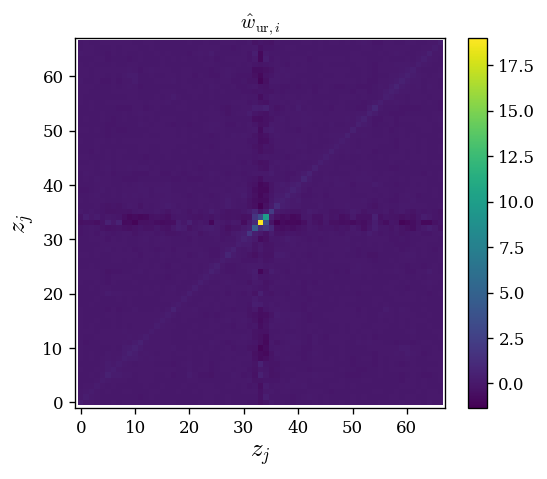

In [4]:

fig, ax = plt.subplots(figsize=(5,4), dpi=120) #plt.figure(figsize=(6,5),dpi=200)

# data_covmat = covariance_matrix
cbar= ax.matshow(covariance_matrix)
# ax.gca().xaxis.tick_bottom()
ax.xaxis.tick_bottom()
ax.set_xlabel(r'$z_j$', fontsize=15)
ax.set_ylabel(r'$z_j$', fontsize=15)

ax.set_xlim(-1,n_stacking)
ax.set_ylim(-1,n_stacking)
plt.colorbar(cbar, ax=ax)
ax.set_title(r'$\hat{w}_{\rm ur,\it i}$')
plt.show()


In [5]:
def normalize_diagonal(matrix):
    """Normalizes the matrix so that diagonal values are 1."""
    new_matrix = np.zeros((n_stacking,n_stacking))#matrix / row_sums[:, np.newaxis]
    for i in range(n_stacking):
        for j in range(n_stacking):
            new_matrix[i,j] = matrix[i,j]/np.sqrt(matrix[i,i]*matrix[j,j])
    return new_matrix

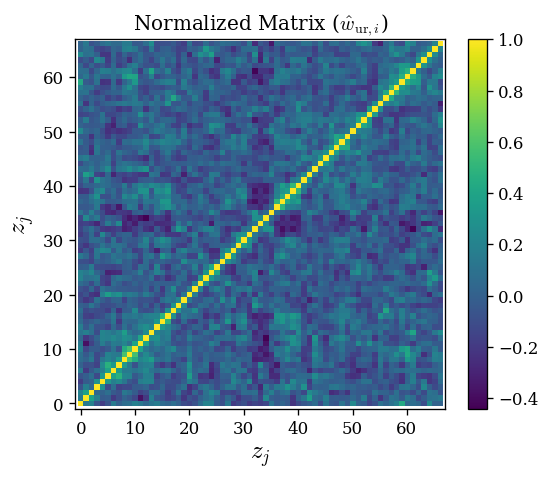

In [6]:
fig, ax = plt.subplots(figsize=(5,4), dpi=120) #plt.figure(figsize=(6,5),dpi=200)


data_covmat_norm = normalize_diagonal(covariance_matrix) #covariance_matrix_shrunked
cbar= ax.matshow(data_covmat_norm)
# ax.gca().xaxis.tick_bottom()
ax.xaxis.tick_bottom()
ax.set_xlabel(r'$z_j$', fontsize=15)
ax.set_ylabel(r'$z_j$', fontsize=15)

ax.set_xlim(-1,n_stacking)
ax.set_ylim(-1,n_stacking)
plt.colorbar(cbar, ax=ax)
ax.set_title(r'Normalized Matrix ($\hat{w}_{\rm ur,\it i}$)')
plt.show()

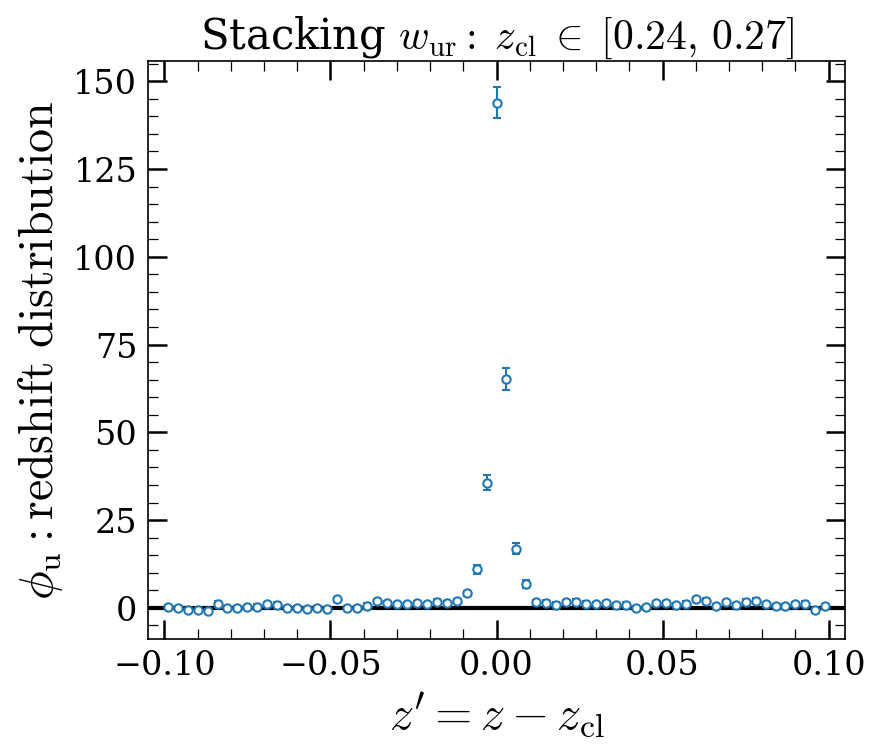

In [7]:
fig = plt.figure(figsize=(6,5),dpi=150)

plt.errorbar(zj_cen_skdbins[0,:],
             wur_mean, 
             yerr = wur_err,
             fmt='o',ms=4, alpha=1, elinewidth=1, capsize=2,
             mfc='white', zorder=3,
             label=r"Normalized stacking w$_{ur}$"+f", (11bins, dz = 0.005)")#"\n"

plt.plot([-1.,1.],[0,0],'k-',lw=2)

plt.xlim(-0.105,0.105)

# plt.xlabel(r'$\rm log_{10}\it M_{\rm 500c}~ \rm [M_{\odot}\it h^{-1}]$',fontsize=20)

plt.xlabel(r"$z^\prime=z-z_{\rm cl}$",fontsize=23)
plt.ylabel(r'$\phi_{\rm u}:\rm redshift~distribution$',fontsize=23) 

# plt.title(rf"$z_{\rm cl}\in [{zi_min:.2f},~{zi_max:.2f}]$")
plt.title(rf"Stacking $w_{{\rm ur}}: \; z_{{\rm cl}}\;\in\;[{zi_min:.2f},\,{zi_max:.2f}]$", fontsize=20)


plt.tick_params(axis='both', which='both', labelsize=8, length=5, width=.6,top=True, right=True,direction='in')
plt.tick_params(axis='both', which='major', labelsize=16, length=9., width=1.2, pad=5,top=True, right=True,direction='in')
plt.minorticks_on()

## Do the double-Gaussian fit and get an initial guess for the best-fit parameters.

In [8]:
# 
from scipy import optimize

import joblib
from astropy import units as u
from astropy.coordinates import SkyCoord
# from lmfit import minimize, Parameters, report_fit
from astropy import constants as const

from IPython.display import display, Math

In [9]:
def vdisp_to_dz(redshift, veldisp):
    return veldisp*(1+redshift)/const.c.to('km/s').value


def twoGaussian_func(x, mu, sigma, sigma2, amp2):
    G1 = (1-amp2) * np.exp((-(x-mu)**2) / (2 * sigma ** 2)) / (sigma*np.sqrt(2*np.pi))
    G2 = amp2 * np.exp((-(x-mu)**2) / (2 * sigma2 ** 2)) / (sigma2*np.sqrt(2*np.pi))
    return G1+G2



def wur_model_gaussian(params, x_z):#, znorm_tags):
    mu1 = params[0]#params['mu'].value ### gaussian_center
    sigma1 =  params[1]#params['sigma'].value ### gaussian1_scatter
    #mu2 = params['mu2'].value
    sigma2 =  params[2]#params['sigma2'].value ### gaussian2_sigma
    amp2 =  params[3]#params['amp2'].value ### gaussian2_amplitude
    #dist = cauchy(dz_par, sigma_par) exp(k_par)
    return twoGaussian_func(x_z, mu1, sigma1, sigma2, amp2)



def residual_covmat_gaussian(params, x, data, data_covmat_inv): #,i_seltags):
    """ calculate the total residual for fits to several data sets held
    in a 2-D array, and modeled by Gaussian functions """
    
    r = data - wur_model_gaussian(params, x)
    chisq = r.T @ data_covmat_inv @ r #np.dot(np.dot(r.T, U), r) #
    return chisq



def regularize_covmat(cov_matrix, parameter):
    C = cov_matrix
    epsilon = parameter * np.min(np.diag(C))
    C_reg = C + epsilon * np.eye(C.shape[0])
    C_inv = np.linalg.inv(C_reg) #(C)#
    print(np.linalg.cond(cov_matrix), 'After regularization', np.linalg.cond(C_reg))
    print('Check determinant')
    print(np.linalg.det(cov_matrix), np.linalg.det(C_reg))
    return C_reg, C_inv

In [10]:
##########################################################

iy = 0
x_fit = zj_cen_skdbins[iy,:] #zcen_11nbin01[:,iy]

x = zj_cen_skdbins[iy,:] #jbins_zcen #np.linspace( -1, 2, 151)
data = wur_mean 
data_err = wur_err

data_covmat, data_covmat_inv = regularize_covmat(covariance_matrix, 0.05)

print(len(x),len(data),data_covmat.shape)
##########################################################

###### Set fitting parameters for Gaussian function ###### 

####################  Gaussian_1 ####################

### Parameter: sigma_1 ###
stacked_iz_center = (zi_min + zi_max)/2.

dz_603 = vdisp_to_dz(stacked_iz_center, 603.0)
vp603_dz = np.sqrt((dz_603)**2+(dz_i)**2) 

dz_1063 = vdisp_to_dz(stacked_iz_center, 1063.0)

vp1063_dz = np.sqrt((dz_1063)**2+(dz_i)**2) 

sig1_min = 0.001 
sig1_max =  0.01
ini_sigma1 = vp603_dz 


### Parameter: amplitude_1 ###

####################  Gaussian_2 ####################
### Parameter: sigma_2 ###
sig2_min = 12.*vp603_dz 
sig2_max =  25.* vp1063_dz 
sigma2_ini =  16.* vp603_dz


print('---------------------------------------------')
print('sig1_min,sig1_max',sig1_min, sig1_max)
print('sig2_min,sig2_max',sig2_min, sig2_max)
print('---------------------------------------------')


params_init = [0.0, ini_sigma1, sigma2_ini, 0.2] 

params_bounds = [(-0.01, 0.01), (sig1_min, sig1_max), (sig2_min,sig2_max), (0.01,0.8)]

result_min = optimize.minimize(residual_covmat_gaussian, params_init, bounds = params_bounds,
                               args=(x, data, data_covmat_inv), #tol=1e-9, #maxiter=4*1e6,
                               method = 'trust-constr', #'Powell', #'trust-constr', #'L-BFGS-B', 'Powell' or 'Nelder-Mead'
                               options={'maxiter': 1000, 'disp': True}) #'ftol': 1e-9, 'gtol': 1e-9, 
                               #method='L-BFGS-B')
print(result_min)

# joblib.dump(result_2g, f'fit_params/TwoGaussians_fit_{iy}_{n11_znbins}wurs_dzi{dz_i}.sav')


2.4180162861201302e+17 After regularization 2226.979028805088
Check determinant
3.99701987339281e-58 7.563992770519602e-41
67 67 (67, 67)
---------------------------------------------
sig1_min,sig1_max 0.001 0.01
sig2_min,sig2_max 0.038646841512107316 0.12196864462906594
---------------------------------------------
`xtol` termination condition is satisfied.
Number of iterations: 139, function evaluations: 990, CG iterations: 343, optimality: 1.86e-04, constraint violation: 0.00e+00, execution time:  0.2 s.
           message: `xtol` termination condition is satisfied.
           success: True
            status: 2
               fun: 516.0380994166871
                 x: [ 4.272e-04  1.917e-03  4.227e-02  2.697e-01]
               nit: 139
              nfev: 990
              njev: 198
              nhev: 0
          cg_niter: 343
      cg_stop_cond: 2
              grad: [ 3.695e-01 -1.295e-02  4.610e-02 -3.601e-03]
   lagrangian_grad: [ 1.837e-05 -1.077e-08  6.037e-07 -1.858e-04]
 

# Check the initial best-fit parameters from ${\tt scipy.optimize}$

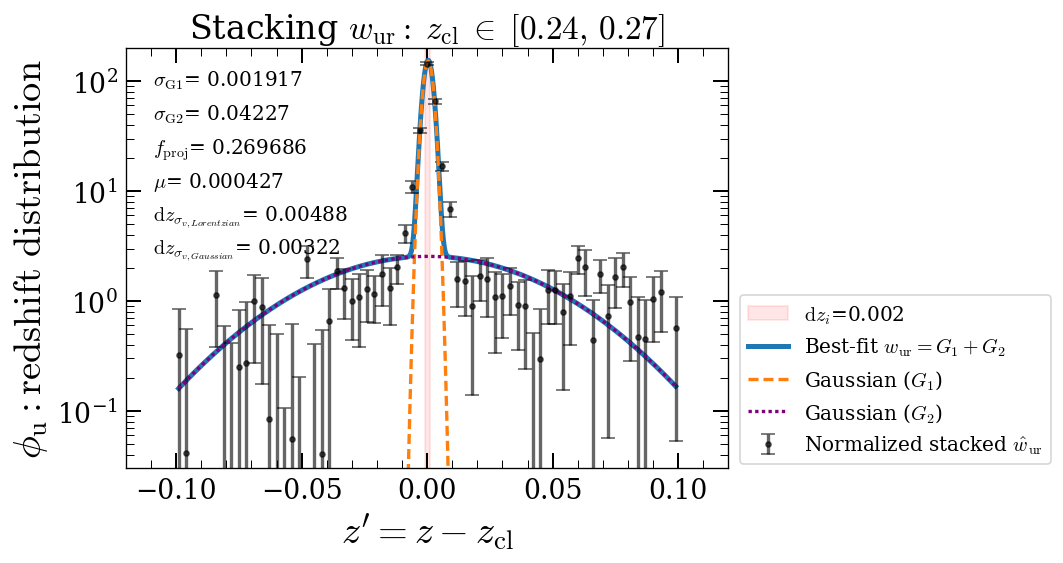

In [11]:

#############################################################################################################
#############################################################################################################
############################################### Making the plot #############################################
#############################################################################################################
#############################################################################################################


def Gaussian1(params, x):
    mu = params[0]#['mu'].value ### gaussian_center
    sigma = params[1]#['sigma'].value ### gaussian_scatter
    amp2 = params[3]#['amp2'].value ### gaussian_amplitude
    return (1-amp2) * np.exp((-(x-mu)**2) / (2 * sigma ** 2)) / (sigma*np.sqrt(2*np.pi))

def Gaussian2(params, x):
    mu2 = params[0]#['mu'].value ### gaussian_center
    sigma2 = params[2]#['sigma2'].value ### gaussian_scatter
    amp2 = params[3]#['amp2'].value ### gaussian_amplitude
    return amp2 * np.exp((-(x-mu2)**2) / (2 * sigma2 ** 2)) / (sigma2*np.sqrt(2*np.pi))


fig = plt.figure(figsize=(9,6),dpi=120)

ax = plt.subplot(1, 1, 1)
plt.rcParams['font.family'] = 'serif'

k=iy 
fxx = x_fit #jbins_zcen

plt.axvspan(-dz_i/2.,dz_i/2.,color='red',alpha=0.1,label=r'$\mathrm{d}z_i$'+f"={dz_i}")

### Gaussian fit

new_x = np.linspace(min(x),max(x),1000)

yG_fit_err = wur_model_gaussian(result_min.x, new_x)
line5, = plt.plot(new_x, yG_fit_err, '-',lw=3, label=r"Best-fit $w_{\rm ur}= G_1+G_2$") #+znarrow_bins_cen[int(iz_center_tag[k])]

line2 = plt.errorbar(x_fit, #jbins_zcen,#[norm_tag], #+znarrow_bins_cen[int(iz_center_tag[k])]
                     data,#[k,norm_tag],
                     yerr = data_err,#[k,norm_tag],
                     fmt='o',ms=3, alpha=.6, color='black', elinewidth=2, capsize=4,
                     label=r"Normalized stacked $\hat{w}_{\rm ur}$")#"\n" +f" r=[{rmind},{rmaxd:.0f}] Mpc"

line7, = plt.plot(new_x, #+znarrow_bins_cen[int(iz_center_tag[k])] 
                  Gaussian1(result_min.x, new_x), 
                  ':',lw=2, dashes=(3,1.5),label=r"Gaussian ($G_1$)") #

line8, = plt.plot(new_x, #+znarrow_bins_cen[int(iz_center_tag[k])] 
                  Gaussian2(result_min.x, new_x), 
                  '--',lw=2, dashes=(1,1), color='purple', 
                  label=r"Gaussian ($G_2$)")


plt.plot([-10.,10.],[0.,0.],'k--')
plt.xlim(-0.12,0.12)

plt.tick_params(axis='both', which='both', labelsize=8, length=5, width=.6,top=True, right=True,direction='in')
plt.tick_params(axis='both', which='major', labelsize=16, length=9., width=1.2, pad=5,top=True, right=True,direction='in')
plt.minorticks_on()


bf_params = result_min.x #result_2g.params

plt.text(.045, .95, r'$\sigma_{\rm G1}$'+f'= {round(bf_params[1],6)}',
        ha='left', va='top', transform=ax.transAxes,fontsize=12)

plt.text(.045, .87, r'$\sigma_{\rm G2}$'+f'= {round(bf_params[2],6)}',
        ha='left', va='top', transform=ax.transAxes,fontsize=12)

plt.text(.045, .79, r'$f_{\rm proj}$'+f'= {round(bf_params[3],6)}',
        ha='left', va='top', transform=ax.transAxes,fontsize=12)

plt.text(.045, .71, r'$\mu$'+f'= {round(bf_params[0],6)}',
        ha='left', va='top', transform=ax.transAxes,fontsize=12)

plt.text(.045, .63, r'$\mathrm{d}z_{\sigma_{v,Lorentzian}}$'+f'= {round(vp1063_dz,5)}',#  ({round(dz_1063,5)})',
         ha='left', va='top', transform=ax.transAxes,fontsize=12)

plt.text(.045, .55, r'$\mathrm{d}z_{\sigma_{v, Gaussian}}$'+f'= {round(vp603_dz,5)}',# ({round(dz_603,5)})',
         ha='left', va='top', transform=ax.transAxes,fontsize=12)


plt.legend(fontsize=12, ncol=1,loc=[1.02,0.01],markerscale=1)#,loc='upper right'

plt.xlabel(r"$z^\prime=z-z_{\rm cl}$",fontsize=23)
plt.ylabel(r'$\phi_{\rm u}:\rm redshift~distribution$',fontsize=23) 
plt.title(rf"Stacking $w_{{\rm ur}}: \; z_{{\rm cl}}\;\in\;[{zi_min:.2f},\,{zi_max:.2f}]$", fontsize=20)


plt.ylim(0.03,200.)
plt.yscale('log')
plt.tight_layout(rect=[0.0, 0.0, 1, .8])

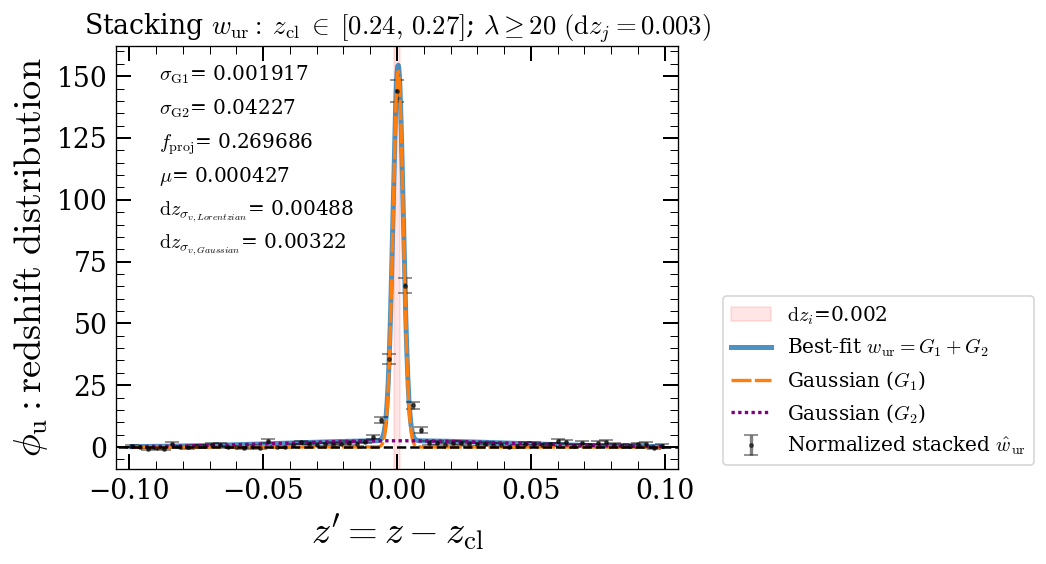

In [12]:

fig = plt.figure(figsize=(9,6),dpi=120)

# ax = plt.subplot(1, 1, 1)
plt.rcParams['font.family'] = 'serif'

k=iy 
fxx = x_fit #jbins_zcen

# line1, = plt.step(gal_zj_cen[:,k], gal_mean_zjnbins[:,k], #+znarrow_bins_cen[int(iz_center_tag[k])]
#                   '-',where='mid',
#                   label = r"$\overline{\it z}_{i,\rm spec}$",
#                   lw=4,alpha=0.8)#,color='#187498')

plt.axvspan(-dz_i/2.,dz_i/2.,color='red',alpha=0.1,label=r'$\mathrm{d}z_i$'+f"={dz_i}")

### Gaussian fit

new_x = np.linspace(min(x),max(x),1000)

yG_fit_err = wur_model_gaussian(result_min.x, new_x)
line5, = plt.plot(new_x, yG_fit_err, '-',lw=3, alpha=0.8,label=r"Best-fit $w_{\rm ur}= G_1+G_2$") #+znarrow_bins_cen[int(iz_center_tag[k])]

line2 = plt.errorbar(x_fit, #jbins_zcen,#[norm_tag], #+znarrow_bins_cen[int(iz_center_tag[k])]
                     data,#[k,norm_tag],
                     yerr = data_err,#[k,norm_tag],
                     fmt='o',ms=2, alpha=.5, color='black', elinewidth=2, capsize=4,
                     label=r"Normalized stacked $\hat{w}_{\rm ur}$")#"\n" +f" r=[{rmind},{rmaxd:.0f}] Mpc"

line7, = plt.plot(new_x, #+znarrow_bins_cen[int(iz_center_tag[k])] 
                  Gaussian1(result_min.x, new_x), 
                  '--',lw=2, dashes=(6,1.), color='#ff7f0e',label=r"Gaussian ($G_1$)") #

line8, = plt.plot(new_x, #+znarrow_bins_cen[int(iz_center_tag[k])] 
                  Gaussian2(result_min.x, new_x), 
                  '--',lw=2, dashes=(1,1), color='purple', 
                  label=r"Gaussian ($G_2$)")


plt.plot([-10.,10.],[0.,0.],'k--')
plt.xlim(-0.105,0.105)


bf_params = result_min.x #result_2g.params

plt.text(.045, .95, r'$\sigma_{\rm G1}$'+f'= {round(bf_params[1],6)}',
        ha='left', va='top', transform=ax.transAxes,fontsize=12)

plt.text(.045, .87, r'$\sigma_{\rm G2}$'+f'= {round(bf_params[2],6)}',
        ha='left', va='top', transform=ax.transAxes,fontsize=12)

plt.text(.045, .79, r'$f_{\rm proj}$'+f'= {round(bf_params[3],6)}',
        ha='left', va='top', transform=ax.transAxes,fontsize=12)

plt.text(.045, .71, r'$\mu$'+f'= {round(bf_params[0],6)}',
        ha='left', va='top', transform=ax.transAxes,fontsize=12)

plt.text(.045, .63, r'$\mathrm{d}z_{\sigma_{v,Lorentzian}}$'+f'= {round(vp1063_dz,5)}',#  ({round(dz_1063,5)})',
         ha='left', va='top', transform=ax.transAxes,fontsize=12)

plt.text(.045, .55, r'$\mathrm{d}z_{\sigma_{v, Gaussian}}$'+f'= {round(vp603_dz,5)}',# ({round(dz_603,5)})',
         ha='left', va='top', transform=ax.transAxes,fontsize=12)

plt.legend(fontsize=12, ncol=1,loc=[1.08,0.01],markerscale=1)#,loc='upper right'


plt.xlabel(r"$z^\prime=z-z_{\rm cl}$",fontsize=23)
plt.ylabel(r'$\phi_{\rm u}:\rm redshift~distribution$',fontsize=23) 
# plt.title(rf"Stacking $w_{{\rm ur}}: \; z_{{\rm cl}}\;\in\;[{zi_min:.2f},\,{zi_max:.2f}]$", fontsize=20)
plt.title(rf"Stacking $w_{{\rm ur}}: \; z_{{\rm cl}}\;\in\;[{zi_min:.2f},\,{zi_max:.2f}]$"+r"; $\lambda \geq 20~(\mathrm{d}z_j=0.003)$",fontsize=16)

plt.tick_params(axis='both', which='both', labelsize=8, length=5, width=.6,top=True, right=True,direction='in')
plt.tick_params(axis='both', which='major', labelsize=16, length=9., width=1.2, pad=5,top=True, right=True,direction='in')
plt.minorticks_on()

plt.tight_layout(rect=[0.0, 0.0, 1, .8])

## Run ${\tt emcee.MCMC}$ to explore the posterior space of parameters.

In [13]:

C_inv = data_covmat_inv

def twoGaussian_func(x, mu, sigma, sigma2, amp2):
    G1 = (1-amp2) * np.exp((-(x-mu)**2) / (2 * sigma ** 2)) / (sigma*np.sqrt(2*np.pi))
    G2 = amp2 * np.exp((-(x-mu)**2) / (2 * sigma2 ** 2)) / (sigma2*np.sqrt(2*np.pi))
    return G1+G2

def log_likelihood_cov(params):
    mu1 = params[0] #['mu'].value ### gaussian_center
    sigma1 = params[1]# ['sigma'].value ### gaussian1_scatter
    sigma2 = params[2] #['sigma2'].value ### gaussian2_sigma
    amp2 = params[3] #['amp2'].value ### gaussian2_amplitude
    
    model = twoGaussian_func(x, mu1, sigma1, sigma2, amp2)
    r = data - model
    return -0.5 * (np.dot(r, np.dot(C_inv, r)))


def log_prior(params):
    mu = params[0]
    sigma = params[1]
    sigma2 = params[2]
    amp2 = params[3]
    lp = 0. if (-0.01 < mu < 0.01 and 0.001 < sigma < 0.006 and 0.01 < amp2 < 0.8 and 0.035 < sigma2 < 0.08) else -np.inf
    return lp

def log_prob(params):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    # return lp + log_likelihood_err(params)
    return lp + log_likelihood_cov(params)



In [14]:
best_fit_params=[]
names = ['mu', 'sigma', 'sigma2', 'amp2']
for i in range(4):
    best_fit_params.append(result_min.x[i])#(result_2g.params[names[i]].value)

np.random.seed(4273663)

best_fit_params = np.array(best_fit_params)
print(best_fit_params)
initial = best_fit_params + 1e-4*np.random.randn(200, 4) #best_fit_params +
nwalkers, ndim = initial.shape
nsteps = 200000

np.seterr(all="ignore")

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob)#, threads=max)
sampler.run_mcmc(initial, nsteps, progress=True);



[0.00042719 0.00191743 0.04226951 0.2696861 ]


100%|██████████| 200000/200000 [15:02<00:00, 221.59it/s]


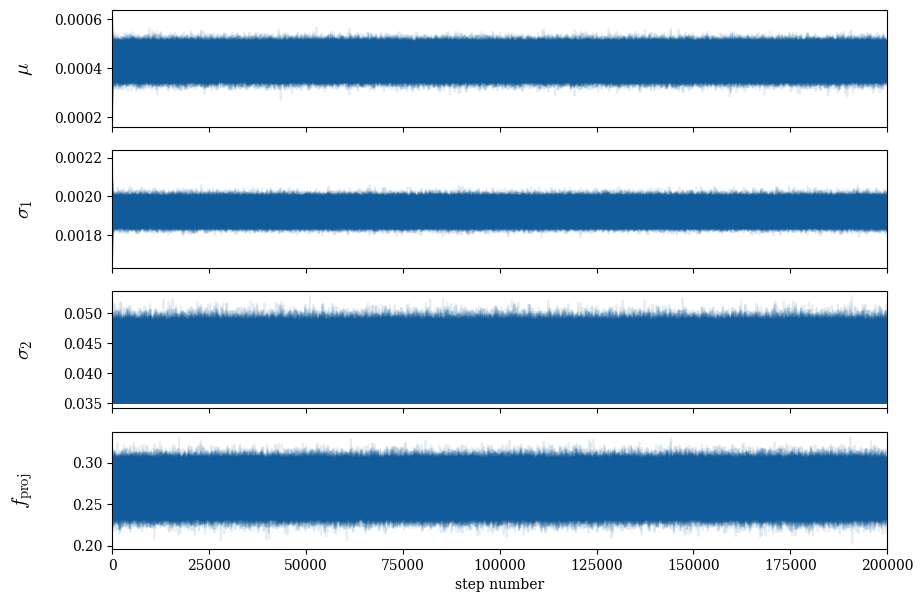

In [15]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels=[r'$\mu$', r'$\sigma_1$', r'$\sigma_2$', r'$f_{\rm proj}$']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "#125B9A", alpha=0.1)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i], fontsize=15)
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [16]:
#from IPython.display import display, Math
labels=[r'$\mu$', r'$\sigma_1$', r'$\sigma_2$', r'$f_{\rm proj}$']

flat_samples = sampler.get_chain(discard=5000, thin=15, flat=True)
print(flat_samples.shape)

best_fit_mcmc = []
best_fit_mcmc_uperr = []
best_fit_mcmc_lowerr = []

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.6f}_{{-{1:.6f}}}^{{{2:.6f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))
    print(mcmc[1])
    best_fit_mcmc.append(mcmc[1])
    best_fit_mcmc_lowerr.append(q[0])
    best_fit_mcmc_uperr.append(q[1])

(2600000, 4)


<IPython.core.display.Math object>

0.00042767966791476655


<IPython.core.display.Math object>

0.0019159475805559112


<IPython.core.display.Math object>

0.041731975257859724


<IPython.core.display.Math object>

0.268764915960668


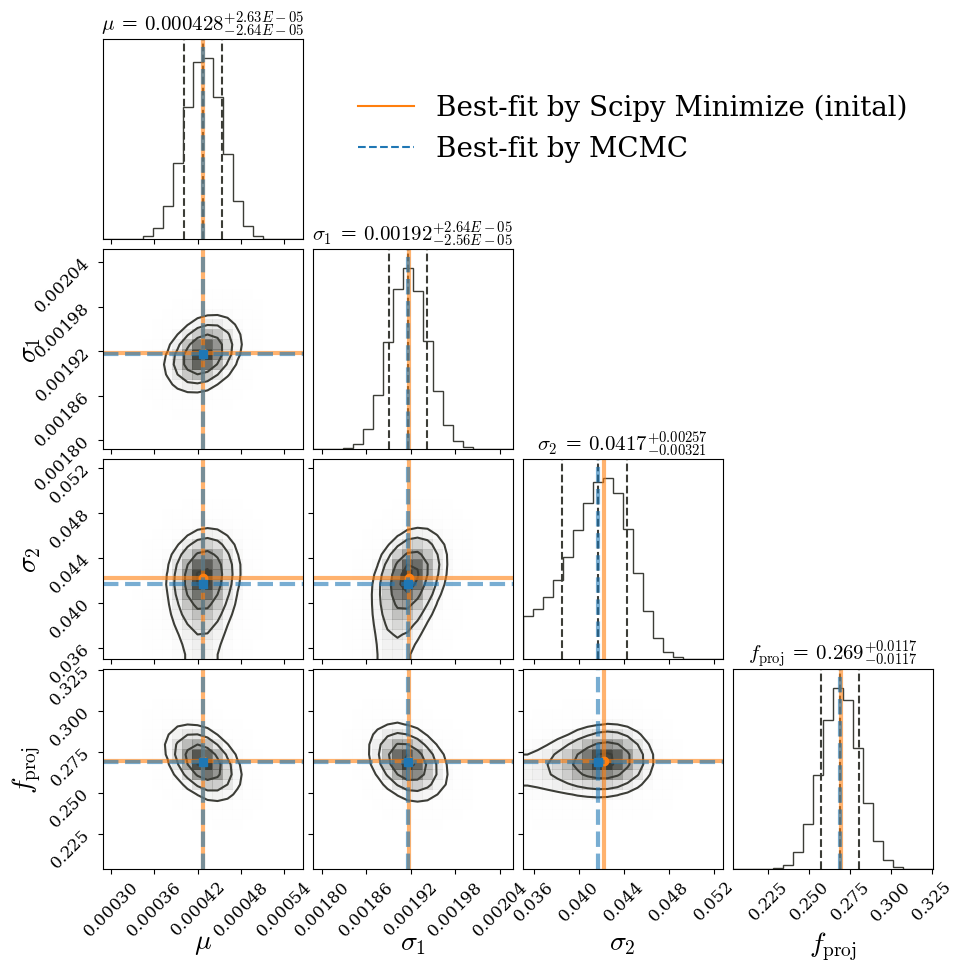

In [17]:
import matplotlib.lines as mlines



fig = corner.corner(flat_samples, #range=set_xrange, #, bins=50
                    show_titles=True, title_fmt='.3G', title_kwargs={'fontsize':15},
                    labels=[r'$\mu$', r'$\sigma_1$', r'$\sigma_2$', r'$f_{\rm proj}$'],#result_emcee.var_names,
                    use_math_text=True, plot_datapoints=False, color='#3C3D37', #contourf=False, #color='orange', , plot_density=False
                    label_kwargs={'fontsize':20}, quantiles=[0.16, 0.5, 0.84], lw=3); #truths=best_fit_mcmc, 

for ax in fig.get_axes():
    ax.tick_params(axis='both', labelsize=12)

corner.overplot_lines(fig, best_fit_params, color="#ff7f0e", ls='-',lw=3, alpha=0.6)
corner.overplot_points(fig, best_fit_params[None], marker='o', ms = 6, color="#ff7f0e")

best_fit_mcmc = np.array(best_fit_mcmc)
corner.overplot_lines(fig, best_fit_mcmc, color="#1f77b4", ls='--',lw=3, alpha=0.6)#,dashes=(1,1))
corner.overplot_points(fig, best_fit_mcmc[None], marker='s', ms = 6, color="#1f77b4")

lines = ['-','--']
colors = [ "#ff7f0e", "#1f77b4"]
sample_labels = ['Best-fit by Scipy Minimize (inital)', 'Best-fit by MCMC']
for il in range(2):
    plt.legend(
        handles=[
            mlines.Line2D([], [], color=colors[il], ls = lines[il], label=sample_labels[il])
            for il in range(2)
        ],
        fontsize=20, frameon=False,
        bbox_to_anchor=(1, ndim), loc="upper right")

    
plt.show()
plt.close()

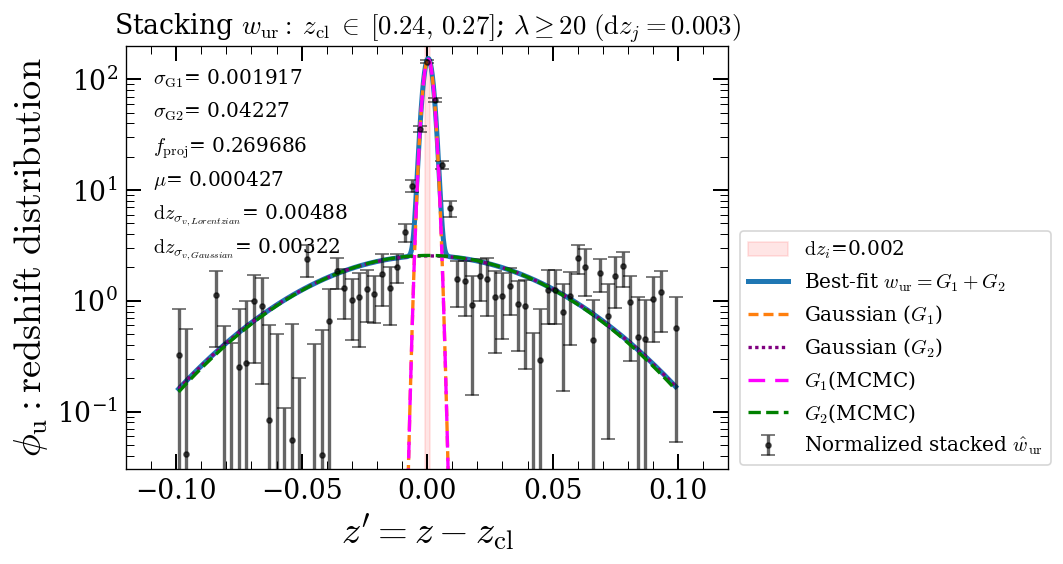

In [18]:

#############################################################################################################
#############################################################################################################
############################################### Making the plot #############################################
#############################################################################################################
#############################################################################################################


# def Gaussian1(params, x):
#     mu = params[0]#['mu'].value ### gaussian_center
#     sigma = params[1]#['sigma'].value ### gaussian_scatter
#     amp2 = params[3]#['amp2'].value ### gaussian_amplitude
#     return (1-amp2) * np.exp((-(x-mu)**2) / (2 * sigma ** 2)) / (sigma*np.sqrt(2*np.pi))

# def Gaussian2(params, x):
#     mu2 = params[0]#['mu'].value ### gaussian_center
#     sigma2 = params[2]#['sigma2'].value ### gaussian_scatter
#     amp2 = params[3]#['amp2'].value ### gaussian_amplitude
#     return amp2 * np.exp((-(x-mu2)**2) / (2 * sigma2 ** 2)) / (sigma2*np.sqrt(2*np.pi))


fig = plt.figure(figsize=(9,6),dpi=120)

ax = plt.subplot(1, 1, 1)
plt.rcParams['font.family'] = 'serif'

k=iy 
fxx = x_fit #jbins_zcen

# line1, = plt.step(gal_zj_cen[:,k], gal_mean_zjnbins[:,k], #+znarrow_bins_cen[int(iz_center_tag[k])]
#                   '-',where='mid',
#                   label = r"$\overline{\it z}_{i,\rm spec}$",
#                   lw=4,alpha=0.8)#,color='#187498')

plt.axvspan(-dz_i/2.,dz_i/2.,color='red',alpha=0.1,label=r'$\mathrm{d}z_i$'+f"={dz_i}")

### Gaussian fit

new_x = np.linspace(min(x),max(x),1000)

yG_fit_err = wur_model_gaussian(result_min.x, new_x)
line5, = plt.plot(new_x, yG_fit_err, '-',lw=3, label=r"Best-fit $w_{\rm ur}= G_1+G_2$") #+znarrow_bins_cen[int(iz_center_tag[k])]

line2 = plt.errorbar(x_fit, #jbins_zcen,#[norm_tag], #+znarrow_bins_cen[int(iz_center_tag[k])]
                     data,#[k,norm_tag],
                     yerr = data_err,#[k,norm_tag],
                     fmt='o',ms=3, alpha=.6, color='black', elinewidth=2, capsize=4,
                     label=r"Normalized stacked $\hat{w}_{\rm ur}$")#"\n" +f" r=[{rmind},{rmaxd:.0f}] Mpc"

line7, = plt.plot(new_x, #+znarrow_bins_cen[int(iz_center_tag[k])] 
                  Gaussian1(result_min.x, new_x), 
                  ':',lw=2, dashes=(3,1.5),label=r"Gaussian ($G_1$)") #

line8, = plt.plot(new_x, #+znarrow_bins_cen[int(iz_center_tag[k])] 
                  Gaussian2(result_min.x, new_x), 
                  '--',lw=2, dashes=(1,1), color='purple', 
                  label=r"Gaussian ($G_2$)")


line9, = plt.plot(new_x, #+znarrow_bins_cen[int(iz_center_tag[k])] 
                  Gaussian1(best_fit_mcmc, new_x), 
                  '--',lw=2, dashes=(5,3), color='magenta',label=r"$G_1$(MCMC)") #

line10, = plt.plot(new_x, #+znarrow_bins_cen[int(iz_center_tag[k])] 
                  Gaussian2(best_fit_mcmc, new_x), 
                  '--',lw=2, color='green', 
                  label=r"$G_2$(MCMC)")

plt.plot([-10.,10.],[0.,0.],'k--')
plt.xlim(-0.12,0.12)
plt.ylim(0.03,200.)
plt.yscale('log')


bf_params = result_min.x #result_2g.params

plt.text(.045, .95, r'$\sigma_{\rm G1}$'+f'= {round(bf_params[1],6)}',
        ha='left', va='top', transform=ax.transAxes,fontsize=12)

plt.text(.045, .87, r'$\sigma_{\rm G2}$'+f'= {round(bf_params[2],6)}',
        ha='left', va='top', transform=ax.transAxes,fontsize=12)

plt.text(.045, .79, r'$f_{\rm proj}$'+f'= {round(bf_params[3],6)}',
        ha='left', va='top', transform=ax.transAxes,fontsize=12)

plt.text(.045, .71, r'$\mu$'+f'= {round(bf_params[0],6)}',
        ha='left', va='top', transform=ax.transAxes,fontsize=12)

plt.text(.045, .63, r'$\mathrm{d}z_{\sigma_{v,Lorentzian}}$'+f'= {round(vp1063_dz,5)}',#  ({round(dz_1063,5)})',
         ha='left', va='top', transform=ax.transAxes,fontsize=12)

plt.text(.045, .55, r'$\mathrm{d}z_{\sigma_{v, Gaussian}}$'+f'= {round(vp603_dz,5)}',# ({round(dz_603,5)})',
         ha='left', va='top', transform=ax.transAxes,fontsize=12)


plt.legend(fontsize=12, ncol=1,loc=[1.02,0.01],markerscale=1)#,loc='upper right'

plt.xlabel(r"$z^\prime=z-z_{\rm cl}$",fontsize=23)
plt.ylabel(r'$\phi_{\rm u}:\rm redshift~distribution$',fontsize=23) 
# plt.title(rf"Stacking $w_{{\rm ur}}: \; z_{{\rm cl}}\;\in\;[{zi_min:.2f},\,{zi_max:.2f}]$", fontsize=20)
plt.title(rf"Stacking $w_{{\rm ur}}: \; z_{{\rm cl}}\;\in\;[{zi_min:.2f},\,{zi_max:.2f}]$"+r"; $\lambda \geq 20~(\mathrm{d}z_j=0.003)$",fontsize=16)

plt.tick_params(axis='both', which='both', labelsize=8, length=5, width=.6,top=True, right=True,direction='in')
plt.tick_params(axis='both', which='major', labelsize=16, length=9., width=1.2, pad=5,top=True, right=True,direction='in')
plt.minorticks_on()


plt.tight_layout(rect=[0.0, 0.0, 1, .8])